In [ ]:
pip install --upgrade matplotlib

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import dataset
normal_df = pd.read_csv("ptbdb_normal.csv", header = None)
abnormal_df = pd.read_csv("ptbdb_abnormal.csv", header = None)

In [3]:
frames = [normal_df, abnormal_df]
global_df = pd.concat(frames)

In [4]:
# Value of each class
global_df[187].value_counts()

1.0    10506
0.0     4046
Name: 187, dtype: int64

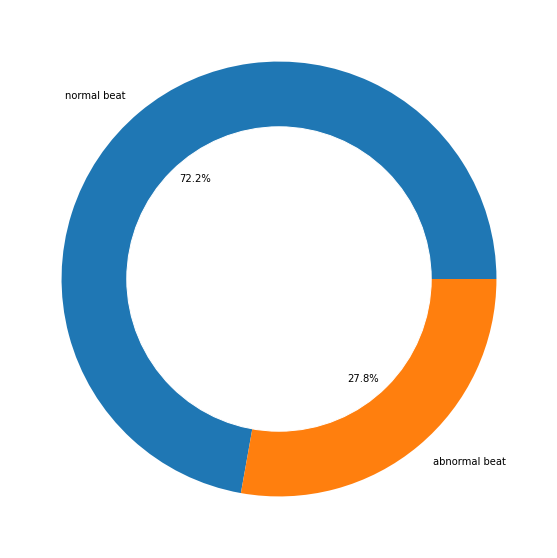

In [5]:
# representation of classes % wise
per_class = global_df[187].value_counts()
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['normal beat','abnormal beat'], colors=['tab:blue','tab:orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [6]:
from sklearn.utils import resample
df_1=global_df[global_df[187]==0]
df_0=(global_df[global_df[187]==1]).sample(n=7000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=7000,random_state=123)


global_df=pd.concat([df_0,df_1_upsample])

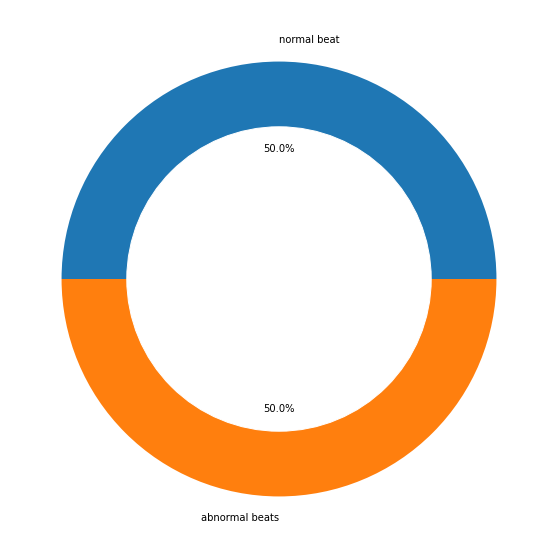

In [7]:
# representation of classes % wise
per_class = global_df[187].value_counts()
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['normal beat','abnormal beats'], colors=['tab:blue','tab:orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [8]:
train_df, test_df = train_test_split(global_df, test_size = 0.2, random_state = 123)

In [9]:
# randomly sampling from each class
classes=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))

In [10]:
# peek on classes
classes

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
1954,0.979513,0.864917,0.445583,0.101152,0.00000,0.230474,0.329706,0.346351,0.365557,0.375160,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9043,0.922947,0.420697,0.291339,0.149044,0.14342,0.165354,0.147357,0.154106,0.154106,0.156355,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


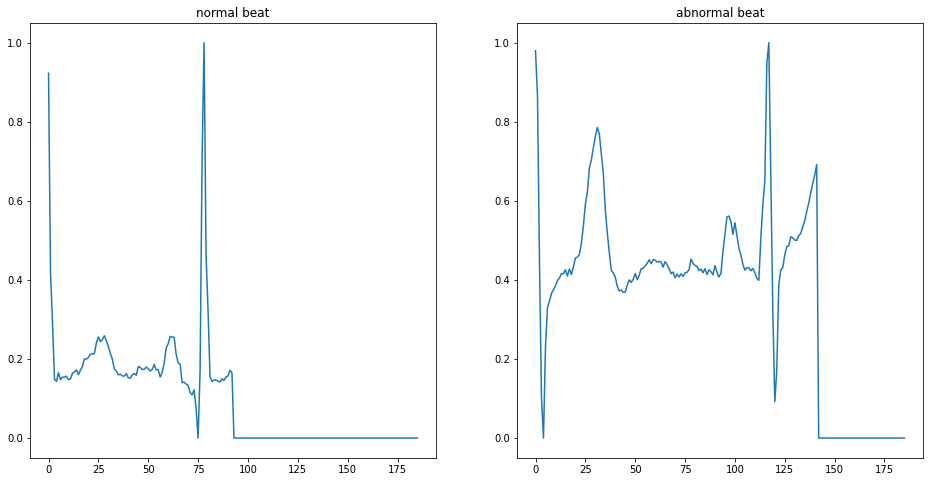

In [11]:
# plotting classes ECG
plt.figure(figsize=(16,8))
# normal
plt.subplot(1, 2, 1)  
plt.plot(classes.iloc[1,:186])
plt.title('normal beat')
# unknown
plt.subplot(1, 2, 2)  
plt.plot(classes.iloc[0,:186])
plt.title('abnormal beat')

# show plot
plt.show()

In [12]:
def plot_hist(class_number,size,min_):
    # get the class data
    img=train_df.loc[train_df[187]==class_number].values
    # crop it
    img=img[:,min_:size]
    # creates a continous steam of data
    img_flatten=img.flatten()
    
    final1=np.arange(min_,size)
    for i in range (img.shape[0]-1):
        tempo1=np.arange(min_,size)
        final1=np.concatenate((final1, tempo1), axis=None)
    print(len(final1))
    print(len(img_flatten))
    plt.hist2d(final1,img_flatten, bins=(80,80),cmap=plt.cm.jet)
    plt.show()

365690
365690


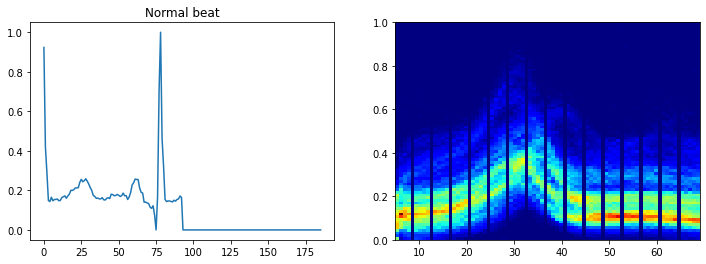

In [13]:
# Normal Beat
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)  
plt.plot(classes.iloc[1,:186])
plt.title('Normal beat')
plt.subplot(1, 2, 2)  
plot_hist(0,70,5)

In [14]:
def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.05,186)
    return (signal+noise)

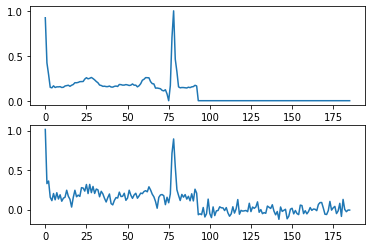

In [15]:
tempo=classes.iloc[1,:186]
bruiter=add_gaussian_noise(tempo)

plt.subplot(2,1,1)
plt.plot(classes.iloc[1,:186])

plt.subplot(2,1,2)
plt.plot(bruiter)

plt.show()

In [16]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [17]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
#for i in range(len(X_train)):
#    X_train[i,:186]= add_gaussian_noise(X_train[i,:186])
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [40]:
# Network
def network(X_train,y_train,X_test,y_test):
    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dropout1 = Dropout(0.4)(dense_end1)
    dense_end2 = Dense(32, activation='relu')(dropout1)
    main_output = Dense(2, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=30,callbacks=callbacks, batch_size=16,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    return(model,history)

In [41]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    confusion_matrix(y_true, prediction)

In [42]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

model,history=network(X_train,y_train,X_test,y_test)

Epoch 1/30
700/700 [==============================] - 277s 396ms/step - loss: 0.3566 - accuracy: 0.8455 - val_loss: 0.4368 - val_accuracy: 0.8057
Epoch 2/30
700/700 [==============================] - 279s 398ms/step - loss: 0.1916 - accuracy: 0.9264 - val_loss: 0.1575 - val_accuracy: 0.9432
Epoch 3/30
700/700 [==============================] - 278s 398ms/step - loss: 0.1312 - accuracy: 0.9514 - val_loss: 0.1021 - val_accuracy: 0.9700
Epoch 4/30
700/700 [==============================] - 280s 400ms/step - loss: 0.1156 - accuracy: 0.9616 - val_loss: 0.6322 - val_accuracy: 0.8307
Epoch 5/30
700/700 [==============================] - 274s 391ms/step - loss: 0.0857 - accuracy: 0.9684 - val_loss: 1.4795 - val_accuracy: 0.6529
Epoch 6/30
700/700 [==============================] - 288s 411ms/step - loss: 0.0692 - accuracy: 0.9747 - val_loss: 0.0656 - val_accuracy: 0.9796
Epoch 7/30
700/700 [==============================] - 290s 414ms/step - loss: 0.0622 - accuracy: 0.9782 - val_loss: 0.0748 -

Accuracy: 99.54%


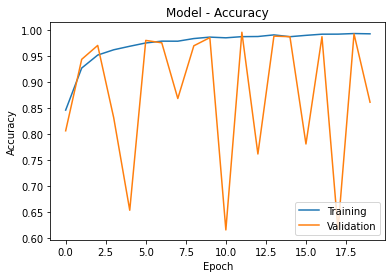

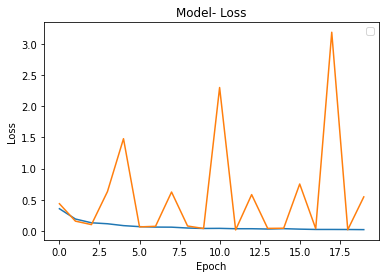

In [43]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

Normalized confusion matrix


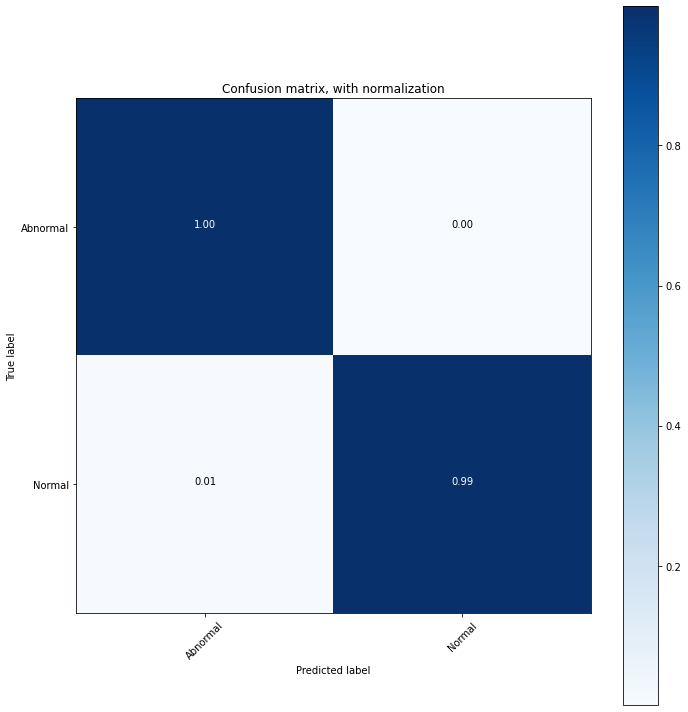

In [44]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['Abnormal', 'Normal'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()

In [45]:
plt.savefig('cfn_mtx_dropout.png')

<Figure size 432x288 with 0 Axes>